In [1]:
import pickle as pkl
# PyTorch
import torch
from torch.utils.data import random_split
# PyG
import torch_geometric
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
# PyTorch-Lightning
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
# Optuna
import optuna
from optuna.samplers import RandomSampler
# NetworkX
import networkx as nx
# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# RDKit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
# Local
from models import GNN_atom
from dataset import XASAtomDataset
from utils.functions import train_model, val_model, seed_everything, count_funct_groups

In [2]:
print(f'Pytorch version: {torch.__version__}')
print(f'PyG version: {torch_geometric.__version__}')
print(f'Lightning version: {L.__version__}')

Pytorch version: 2.4.1+cpu
PyG version: 2.5.3
Lightning version: 2.4.0


In [3]:
# --- Path raw directory containing the data
path = "../"
dataset = XASAtomDataset(path)

/home/samjhall/miniconda3/envs/pyg-schnet/lib/python3.11/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) an

Total number of molecules 318


Done!


In [4]:
# --- Show detail of the dataset
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print('')

# --- Show details of the first molecule/graph in dataset
data = dataset[20]

print(data)
print('------------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

XASAtomDataset(318)
------------
Number of graphs: 318
Number of features: 15
Number of classes: 0

Data(x=[29, 15], edge_index=[2, 76], edge_attr=[76, 5], spectrum=[29, 200], idx=[1], smiles='C123[C:2]4=[C:1]([H:29])[C:23]([H:36])([H:37])[C:22]5=[C:21]([H:35])[C:19]([H:34])([H:40])[C:18]67[C:16]([C:12]8([H:41])[C:8]9=[C:4]1[C:6]1([C:5]([H:31])=[C:3]4[H:30])[C:7]([H:32])([C:9]([H:33])([H:39])[C:10]9([O:25][H:38])[C:11]([H:43])=[C:13]([H:44])[C:14]8=[C:15]([H:42])[C:17]6=[O:24])[O:28]1)([C:20]25[O:26]3)[O:27]7', mol='R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_1_iEPOXY_2_ieEPOXY_1_2')
------------
Number of nodes: 29
Number of edges: 76
Average node degree: 2.62
Has isolated nodes: False
Has self loops: False
Is undirected: True


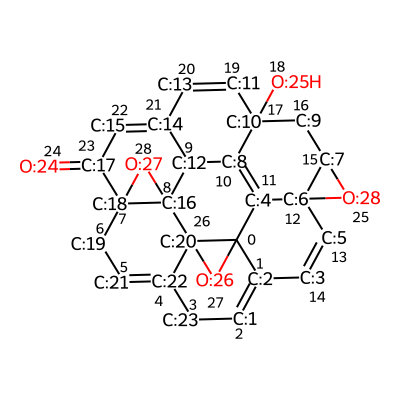

In [5]:
# --- View molecule using RDKit
IPythonConsole.drawOptions.addAtomIndices=True
IPythonConsole.drawOptions.annotationFontScale=0.8
IPythonConsole.molSize = 400,400
mol = Chem.MolFromSmiles(data.smiles)
mol

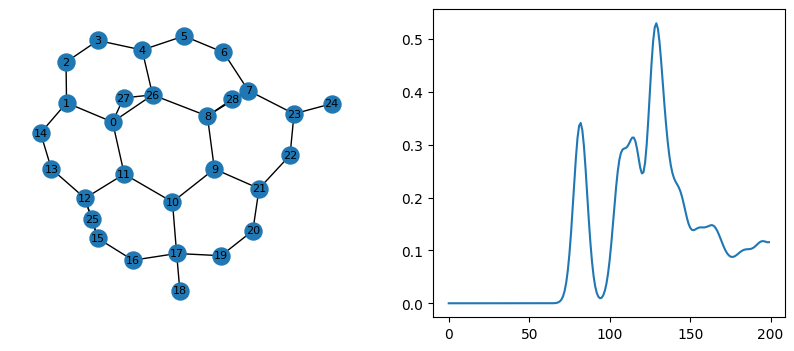

In [6]:
# --- Create subplot for plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# --- Show graph representation of molecule
mol_graph = to_networkx(data, to_undirected=True)
nx.draw(mol_graph, ax=ax1, with_labels=True, node_size=150, font_size=8)

# --- Show molecule spectrum
ax2.plot(data.spectrum[0])
plt.show()

In [7]:
# Random seed to reproduce data split
generator = torch.Generator().manual_seed(2)
# Split dataset into train, validation and test sets
train_data, val_data, test_data = random_split(dataset, [0.75, 0.125, 0.125], generator)

print(f'Length of training data: {len(train_data)}')
print(f'Length of validation data: {len(val_data)}')
print(f'Length of testing data: {len(test_data)}')

# torch.save(test_data, '../processed/test_coronene_pyg.pt')

Length of training data: 239
Length of validation data: 40
Length of testing data: 39


In [8]:
# Load data splits into DataLoaders
train_loader = DataLoader(train_data, batch_size=239, shuffle=True)
val_loader = DataLoader(val_data, batch_size=40, shuffle=False)

print(f'Number of batches in train loader: {len(train_loader)}')
print(f'Number of batches in val loader: {len(val_loader)}')

Number of batches in train loader: 1
Number of batches in val loader: 1


#### Tuning

### Run training on best model

In [9]:
num_tasks = 200
num_layers = 3 #gnn_params['num_layers']
# hidden_channels = gnn_params['hidden_channels']
in_channels = [15, 64, 128] # [hidden_channels] * (num_layers - 1)
# in_channels.insert(0, 15)
out_channels = [64, 128, 256] # [hidden_channels] * num_layers
gnn_type = 'gcn' #gnn_params['gnn_type']
heads = 1
drop_ratio = 0.25 # gnn_params['drop_ratio']
graph_pooling = 'mean'

seed_everything(199)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model  = GNN_atom(num_tasks, num_layers, in_channels, out_channels,
                   gnn_type, heads, drop_ratio, graph_pooling).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=25, min_lr=0.0000001)

num_epochs = 300
train_losses = []
val_losses = []
results = []

for epoch in range(num_epochs):
    loss = train_model(model, train_loader, optimizer, device)

    val_error = val_model(model, val_loader, device)

    scheduler.step(val_error)
    
    train_losses.append(loss)
    val_losses.append(val_error)

    current_lr = optimizer.param_groups[0]['lr']

    results.append((epoch, loss, val_error, current_lr))

    if epoch % 2 == 0:
        print(f'Epoch: {epoch:03d}, LR: {current_lr:.5f}, TrainLoss: {loss:.5f}, ValLoss: {val_error:.5f}')

AttributeError: 'GlobalStorage' object has no attribute 'atom_num'

In [10]:
# name = 'gcn_test.pth' #gnn_params['gnn_type'] + '_model.pth'

# torch.save(model.state_dict(), name)